# Time Series Analysis
by Fabien Nugier

Time series compose a very wide field of research which have applications in astrophysics, telecommunications, weather forcasting, economy and finance, etc. Numerous techniques have been employed to study them, as can be seen on the associated Wiki page: https://en.wikipedia.org/wiki/Time_series
        
In this notebook, I simulate a few random processes referred as **linear time series** and extensively employed in finance, more precisely in **portfolio analysis**. The processes are **AR(p)**, **MA(q)** and **random walk** processes that I recently had the opportunity to study. Considering the generality of these models, they can be applied to other fields and complexified at will.

A large part of the theoretical knowledge employed in these simulations is very clearly explained in the book:

**"Analysis of Financial Time Series", by Ruey S. Tsay, Univ. of Chicago.**
    
If you are reading this notebook, you should read that book! :-)

### Libraries

In [3]:
# The basis stuffs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For fits
from sklearn.linear_model import LinearRegression
from scipy import optimize

# To loop over i,j simultaneously
import itertools

# For heatmap
import seaborn as sns

In [4]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

# AR(1) Model

In this simple model, we make the return of a stock $i$ at time $t$ depend on the return at time $t-1$, so that we can study the effect of memory within stocks. This gives the **Simple Auto-Regressive AR(1) model** in which we also add a white noise $\epsilon$:

$$
r_i^t = g_i^0 + g_i^1 r_i^{t-1} + \sigma \, \epsilon_i^t
$$

where:
- $r_i^t$ is the return of stock $i$ at time $t$,
- $g_i^0$ is a time-independent constant for each stock $i$,
- $\epsilon_i^t$ is the noise "idiosyncratic" to the stock $i$ at time $t$,
- $\sigma$ is the strength of this noise (we will keep it to 1).

**About noise:** the noise $\epsilon_i^t$ is represented by a distribution which is centered (mean zero, i.e. "white" noise) and normal with variance 1 (normalized noise). To this "idiosyncratic" noise in the model could be added a "market noise" $\eta^t$, independent from stock and $\epsilon$, but depending on time.

The number of stocks in the portfolio is $N=100$ and the time period under consideration is $T = 2000$.

In [5]:
N = 100
T = 2000
sig = 1

We generate the constants $g^0_i$ and $g^1_i$ for each stock from a normal distribution $N(0,0.02)$. In principle we don't need a distribution for these values since it should be set by the market, but we need them to simulate the stocks.

In [6]:
s1 = 0.3
g0 = np.random.normal(loc=0., scale=0.02, size=N)
g1 = np.random.normal(loc=0., scale=s1, size=N)

We also generate the white noise for each stocks:

In [7]:
eps = np.random.normal(loc=0, scale=1., size=(T,N))

Let us now build a **portfolio of stocks** over time, we place each stock on a column and time runs along the raws.

In [8]:
np.random.seed(1234)

def buildPF_AR1model(sig,g0,g1,eps):
    # Dimensions
    if (len(g0)!=len(g1) or len(g0)!=eps.shape[1]):
        ValueError('Dimension error.')
    else:
        N = len(g0)
        T = eps.shape[0]

    # Building portfolio
    PF = np.zeros((T,N))
    for i in range(N):
        for t in range(1,T,1):
            PF[t,i] = g0[i] + g1[i] * PF[t-1,i] + sig * eps[t,i]
            
    return PF

In [9]:
PF = buildPF_AR1model(sig,g0,g1,eps)

Here is a sample of our portfolio stocks over time:

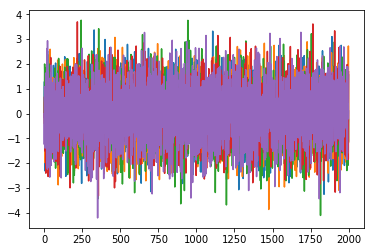

In [10]:
plt.plot(PF[:,0:5])

Let us plot the first two stocks against each other:

Text(0.5, 1.0, 'Plot of 2 stocks agains each other')

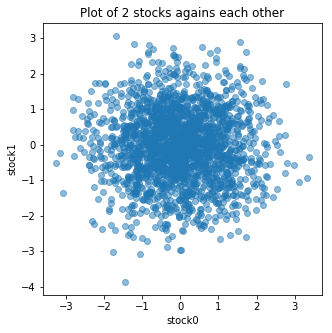

In [11]:
plt.figure(figsize=(5,5))
plt.scatter(PF[:,0], PF[:,1], alpha=0.5)
plt.xlabel("stock0")
plt.ylabel("stock1")
plt.title("Plot of 2 stocks agains each other")

Let us compute the experimental $g_i$'s by taking their average over time. We should notice here that we assume statistical averages to be equal to time averages, which is known as **ergodicity**, and we have to assume also for that that we are having slowly time-evolving stocks, also know as **weak stationarity condition**.

In [12]:
def compgE (PF):
    N = PF.shape[1]
    gE = np.zeros(N)
    for i in range(N):
        gE[i] = PF[:,i].mean()
    return gE

In [13]:
g0E = compgE(PF)

Let's compare the experimental $g_i^E$ with $g_i$:

In [14]:
def compare_g_gE (g, gE):
    # Fitting function
    x = g.reshape(-1,1)
    y = gE.reshape(-1,1)
    lm = LinearRegression()
    lm.fit(x,y)

    # Plotting
    plt.figure(figsize=(5,5))
    plt.scatter(g,gE)
    xfit = np.linspace(g.min(),g.max(),20).reshape(-1,1)
    plt.plot(xfit, lm.predict(xfit), label='Fit', color='red')
    plt.xlabel('g')
    plt.ylabel('$g_E$')
    plt.legend()
    plt.show()

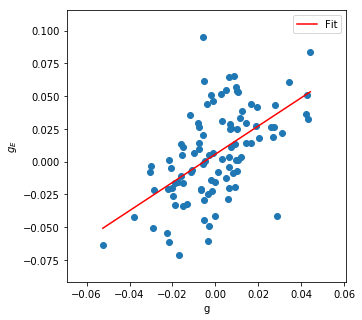

In [15]:
compare_g_gE(g0,g0E)

The strong correlation attests that these two assumptions are satisfied.

In the case of the AR(1) model we can build a function that computes the theoretical average (easy to prove by hand calculation):

In [17]:
def comp_r_avgth (g0,g1):
    if(len(g0)!=len(g1)):
        ValueError('Dimension Error!')
    N = len(g0)
    gth = np.zeros(N)
    for i in range(N):
        gth[i] = g0[i] / (1-g1[i])
    return gth

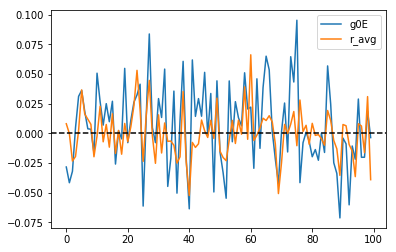

In [18]:
r_avg = comp_r_avgth(g0,g1)

plt.plot(g0E, label='g0E')
plt.plot(r_avg, label='r_avg')
plt.axhline(y=0., color='k', linestyle='--')
plt.legend()

We can see, when T is large enough, that the theoretical computation of the average return is correct.

Let us plot the first 2 stocks over time:

Text(0.5, 0, 't')

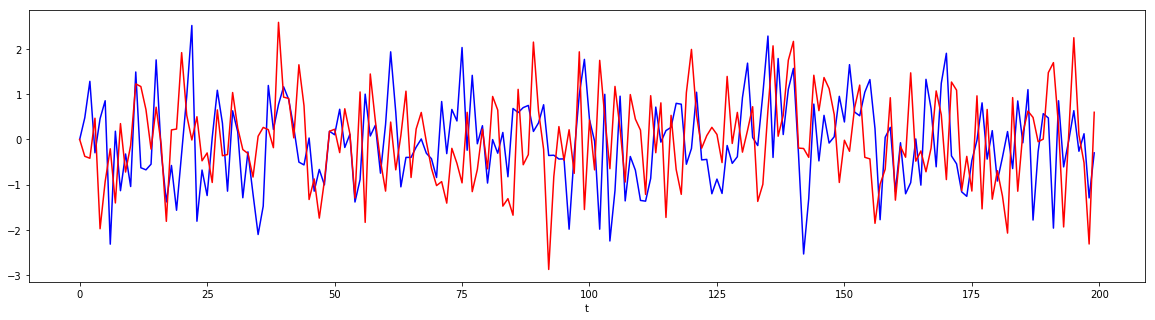

In [23]:
plt.figure(figsize=(20,5))
plt.plot(PF[:200,0], color='b')
plt.plot(PF[:200,1], color='r')
plt.xlabel('t')

We are not expecting to see any correlation between stock0 and stock1, for the simple reason that there is no market noise that can push the different stocks in the same direction, hence creating a correlation between them.

### Covariance matrix $C$

Let us compute the covariance matrix experimentally:

In [24]:
def compCE (PF, gE):
    T = PF.shape[0]
    N = PF.shape[1]
    C = np.zeros((N,N))
    for i, j in itertools.product(range(N), range(N)):
        # Summing over t and diving by T
        TMP = (PF[:,i] - gE[i]) * (PF[:,j] - gE[j])
        C[i,j] = TMP.sum() / T
    return C

And theoretically:

In [25]:
def compCth_AR1 (N,sig,g0,g1):
    I = np.identity(N)
    C = np.zeros((N,N))
    for i,j in itertools.product(range(N),range(N)):
        # Old calculation
        # ri = g0[i] / (1-g1[i])
        # rj = g0[j] / (1-g1[j])
        # var = (sig**2 * I[i,j] + g0[i]*g0[j] + g0[i]*g1[j]*rj + g0[j]*g1[i]*ri) / (1-g1[i]*g1[j])
        
        # Shorter expression
        C[i,j] = sig**2 * I[i,j] / (1-g1[i]*g1[j])
    return C

And create a function to compare these two:

In [26]:
def compareMatrices (A, B, subN=10, cmap='coolwarm'):
    if(A.shape!=B.shape):
        ValueError('Dimension Error!')
    
    vmin = min(A.min(), B.min())
    vmax = max(A.max(), B.max())

    fig, axs = plt.subplots(ncols=3, gridspec_kw=dict(wspace=0.1, width_ratios=[8,8,0.5]), figsize=(10,5))
    
    if(subN <= 10):
        annot_opt = True
    else:
        annot_opt = False
        
    sns.heatmap(A[0:subN,0:subN], annot=annot_opt, cbar=False, ax=axs[0], cmap=cmap, vmin=vmin, vmax=vmax)
    sns.heatmap(B[0:subN,0:subN], annot=annot_opt, yticklabels=False, cbar=False, ax=axs[1], cmap=cmap, vmin=vmin, vmax=vmax)

    fig.colorbar(axs[1].collections[0], cax=axs[2])
    plt.show()

The experimental covariance matrix is:

In [27]:
CE = compCE(PF, g0E)

And the theoretical covariance matrix is:

In [28]:
Cth = compCth_AR1(N,sig,g0,g1)

In [29]:
print(CE[0:5,0:5],'\n')
print(Cth[0:5,0:5])

[[ 1.04301731 -0.00878584  0.01028316  0.00287242 -0.03934657]
 [-0.00878584  1.01835842 -0.00134618 -0.017675    0.04880777]
 [ 0.01028316 -0.00134618  1.19543027  0.0292623   0.01476227]
 [ 0.00287242 -0.017675    0.0292623   1.06577946 -0.00138798]
 [-0.03934657  0.04880777  0.01476227 -0.00138798  1.19827829]] 

[[1.06988604 0.         0.         0.         0.        ]
 [0.         1.00024313 0.         0.         0.        ]
 [0.         0.         1.22356596 0.         0.        ]
 [0.         0.         0.         1.04720935 0.        ]
 [0.         0.         0.         0.         1.14751518]]


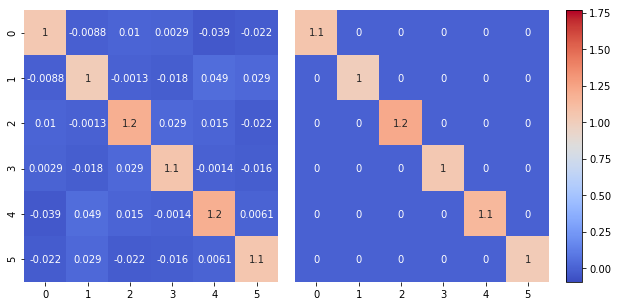

In [30]:
compareMatrices(CE,Cth,6)

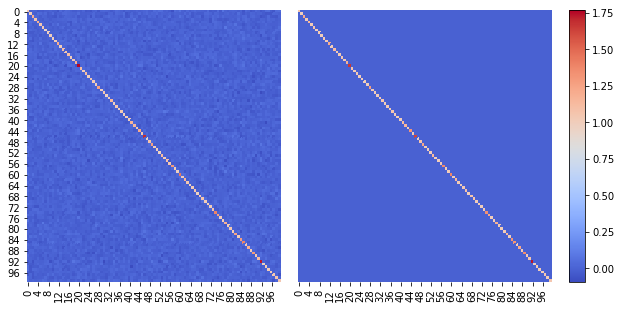

In [31]:
compareMatrices(CE,Cth,N)

The experimental covariance matrix looks fine and very close to the theoretical covariance matrix which is diagonal.

### Two types of portfolios

Let us define the total return of the portfolio:
$$
G^t = \sum_i w_i \, r_i^t
$$
where the $w_i$'s represent the number of stock shares we would hold (positive value) or short (negative value).

We define two cases:
- **case I :**  $w_i = 1/N$, i.e. we are taking long positions on every stock of the market (assuming our $N=100$ stocks represent the whole market).
- **case II :**  $w_i = (-1)^i / N$, i.e. we are long on half the stocks and shorting the second half.

In [32]:
def compG (PF):
    T = PF.shape[0]
    N = PF.shape[1]
    GI = np.zeros(T)  # Longing all the market
    GII = np.zeros(T) # Longing half, shorting half market
    
    for t in range(T):
        for i in range(N):
            GI[t] += PF[t,i] / N
            GII[t] += (-1)**i * PF[t,i] / N
            
    return GI, GII

Let us see the two different portfolios (longing all market and hedging the market):

In [33]:
GI, GII = compG(PF)

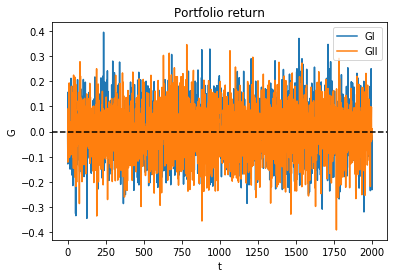

In [35]:
plt.plot(GI, label='GI')
plt.plot(GII, label='GII')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('t')
plt.ylabel('G')
plt.title('Portfolio return')
plt.legend()

The two portfolios seem to have the same volatility, as attested by my calculations (not presented here but proving that the variance of $G^t$ depends on $(w_i)^2$ is sufficient for that conclusion).

### Lag-L autocovariance function of returns

We compute the autocovariance function for a given stock $i$:
$$
\gamma_i^l = Cov(r_i^t - \overline{r_i} \,,\, r_i^{t-l} - \overline{r_i})
$$
where the overline denotes the average over time, as used in the covariance. We assume ergodicity, i.e. time averages equate statistical averages.

In [36]:
def compLagL_autocov (L, PF, gE):
    if(PF.shape[1]!=len(gE)):
        ValueError('Dimension Error!')

    N = PF.shape[1]
    T = PF.shape[0]
    gamma = np.zeros((L,N))

    for i in range(N):
        for l in range(L):
            for t in range(l,T):
                gamma[l,i] += (PF[t,i]-gE[i])*(PF[t-l,i]-gE[i])
            gamma[l,i] = gamma[l,i]/T
    
    return gamma

Let's compute the lag-L autocovariance function $\gamma^L_i$ and the ACF $\rho^L_i$ for each stock:

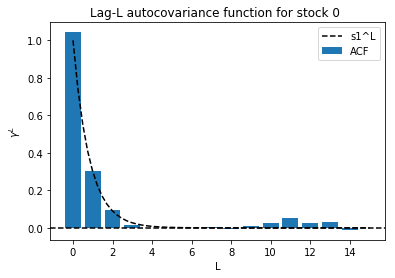

In [37]:
L = 15
gamma = compLagL_autocov(L,PF,g0E)

stock_id = 0
plt.bar(range(L), gamma[:,stock_id], label='ACF')
x0 = np.linspace(0,15,62)
y0 = [s1**x for x in x0]
plt.plot(x0, y0, color='k', linestyle='--', label='s1^L')
plt.axhline(y=0., color='k', linestyle='--')
plt.xlabel('L')
plt.ylabel('$\gamma^L$')
plt.title('Lag-L autocovariance function for stock 0 ')
plt.legend()

We also plotted in dashed black line the theoretical expectation for that function, given by $(g_i^0)^L$.

We can also define the **autocorrelation function (ACF)** for a given stock $i$:
$$
\rho_i^l = \frac{Cov(r_i^t - \overline{r_i} \,,\, r_i^{t-l} - \overline{r_i})}{Var(r_i^t) \, Var(r_i^{t-l})} = \frac{\gamma^l_i}{\gamma^0_i}
$$

In [38]:
def compACF (L, PF, gE):
    if(PF.shape[1]!=len(gE)):
        ValueError('Dimension Error!')
    N = PF.shape[1]
    T = PF.shape[0]
    
    # Computing the auto-covariance matrix
    gamma = compLagL_autocov(L,PF,gE)
    
    # Building the variance matrix
    gamma0 = np.zeros(N)
    for i in range(N):
        for t in range(T):
            gamma0[i] += (PF[t,i]-gE[i])*(PF[t,i]-gE[i])
        gamma0[i] = gamma0[i]/T
     
    # Building the ACF matrix
    rho = np.zeros((L,N))
    for l in range(L):
        for i in range(N):
            rho[l,i] = gamma[l,i] / gamma0[i]
            
    return rho

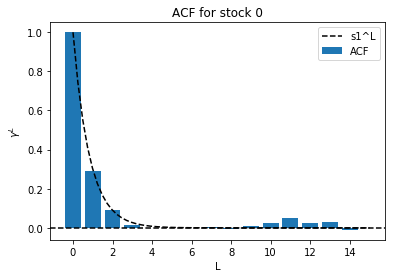

In [39]:
L = 15
ACF = compACF(L,PF,g0E)

stock_id = 0
plt.bar(range(L), ACF[:,stock_id], label='ACF')
x0 = np.linspace(0,15,62)
y0 = [s1**x for x in x0]
plt.plot(x0, y0, color='k', linestyle='--', label='s1^L')
plt.axhline(y=0., color='k', linestyle='--')
plt.xlabel('L')
plt.ylabel('$\gamma^L$')
plt.title('ACF for stock 0')
plt.legend()

We can see that because the scale of the normal distribution that generated the values for $g_i^1$ we have the lag-L autocovariance and the ACF which have a non-negligible value at $L=1$.

**This shows that the AR(1) model is indeed a 1-step memory process!**

----

# AR(p) Model

The extension to a more complicated **Auto-Regression AR(p) model** with white noise $\epsilon$ should be quite straightforward:

$$
r_i^t = g_i^0 + g_i^1 r_i^{t-1} + g_i^2 r_i^{t-2} + \ldots + g_i^p r_i^{t-p} + \sigma \, \epsilon_i^t
$$

In [40]:
N = 100
T = 2000
P = 5

We first create the arbitrary coefficients $g_i^k$ with $i=1,\ldots,N$ and $k=1,\ldots,P$. We need positive values for the standard deviation of the Normal distributions, so we use a Poisson distribution to generate them.

In [41]:
g0 = np.random.normal(loc=0., scale=s1, size=N)

In [42]:
s = np.random.poisson(lam=30,size=P) / 100. # Generating values for distributions of k=2,...,P
print(s)

[0.38 0.35 0.26 0.27 0.2 ]


In [43]:
g = np.zeros((P,N))
for k in range(P):
    g[k] = np.random.normal(loc=0., scale=s[k], size=N)

In [44]:
eps = np.random.normal(loc=0, scale=1., size=(T,N))

The model is computed in the following function:

In [45]:
np.random.seed(1234)

def buildPF_ARPmodel(sig,g0,g,eps):
    # Dimensions
    if (len(g0)!=len(g[0]) or len(g0)!=eps.shape[1]):
        ValueError('Dimension error.')
    else:
        N = len(g0)
        T = eps.shape[0]

    # Building portfolio
    PF = np.zeros((T,N))
    for i in range(N):
        for t in range(P,T,1):
            sumPFpast = 0
            for k in range(P):
                sumPFpast += g[k,i] * PF[t-(k+1),i]
            PF[t,i] = g0[i] + sumPFpast + sig * eps[t,i]
            
    return PF

In [46]:
PF = buildPF_ARPmodel(sig,g0,g,eps)

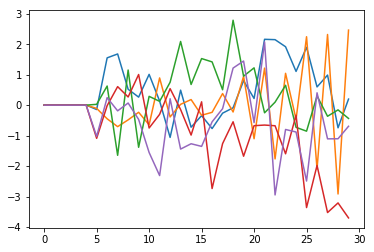

In [47]:
plt.plot(PF[:30,0:5])

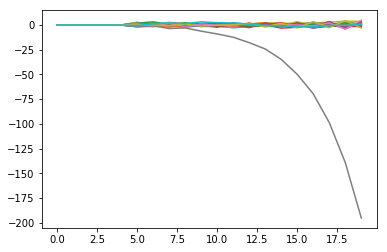

In [48]:
plt.plot(PF[:20,0:30])

Plotting the two stocks against each other:

Text(0.5, 1.0, 'Plot of 2 stocks agains each other')

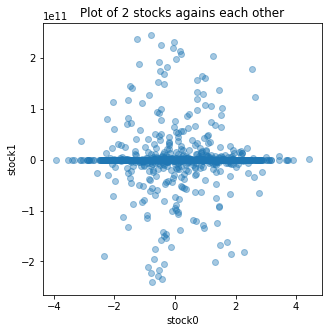

In [51]:
plt.figure(figsize=(5,5))
plt.scatter(PF[:,0], PF[:,1], alpha=0.4)
plt.xlabel("stock0")
plt.ylabel("stock1")
plt.title("Plot of 2 stocks agains each other")

Text(0.5, 0, 't')

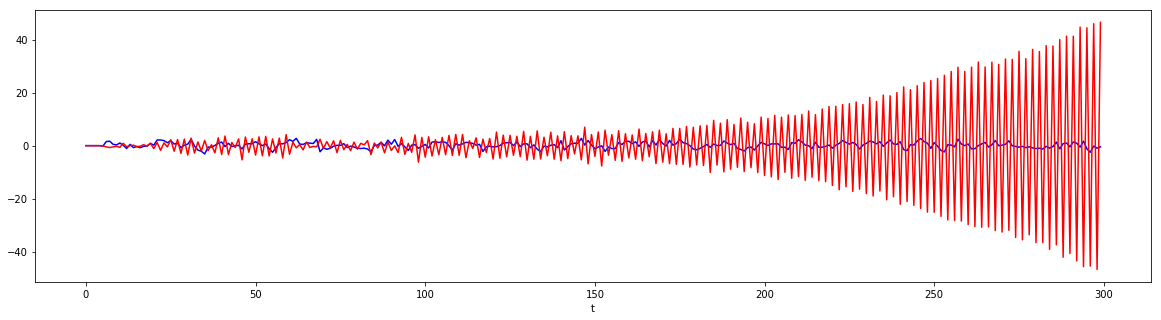

In [52]:
plt.figure(figsize=(20,5))
plt.plot(PF[:300,0], color='b')
plt.plot(PF[:300,1], color='r')
plt.xlabel('t')

It can be useful to visualize the coefficients of the equation in order to better understand later which stock diverges in value.

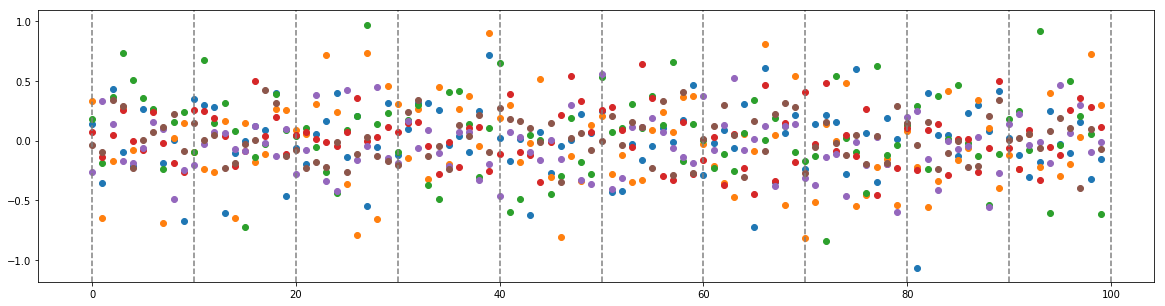

In [53]:
plt.figure(figsize=(20,5))
plt.scatter(range(N),g0)
for k in range(P):
    plt.scatter(range(N),g[k,:])
for m in range(0,N+1,10):
    plt.axvline(x=m, color='grey', linestyle='--')

For example, we can see from this plot that stock number 27 has a coefficient pretty close to 1, and we can indeed see a diverging behaviour in it:

Text(0.5, 0, 't')

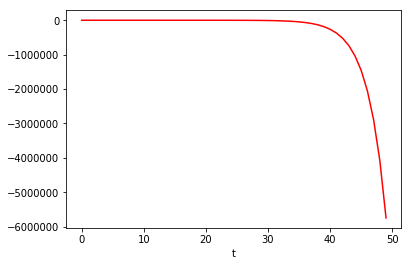

In [54]:
plt.plot(PF[:50,27], color='r')
plt.xlabel('t')

In [55]:
g0E = compgE(PF)

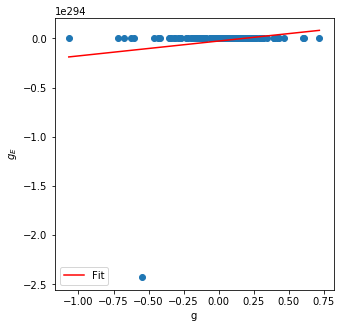

In [56]:
compare_g_gE(g0,g0E)

In [57]:
def comp_r_avgth (g0,g):
    if(len(g0)!=len(g[0])):
        ValueError('Dimension Error!')
    N = len(g0)
    gth = np.zeros(N)
    for i in range(N):
        gth[i] = g0[i] / (1 - g[:,i].sum())
    return gth

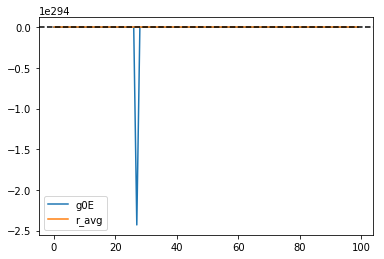

In [58]:
r_avg = comp_r_avgth(g0,g)

plt.plot(g0E, label='g0E')
plt.plot(r_avg, label='r_avg')
plt.axhline(y=0., color='k', linestyle='--')
plt.legend()

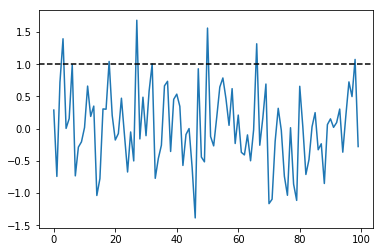

In [59]:
test = np.zeros(N)
for i in range(N):
    test[i] = g[:,i].sum()
plt.plot(test)
plt.axhline(y=1., color='k', linestyle='--')

We can see that the average of return blows up when the denominator $1 - g^1 - g^1 - \ldots - g^P$ approaches 1 (for which the relation does not apply).

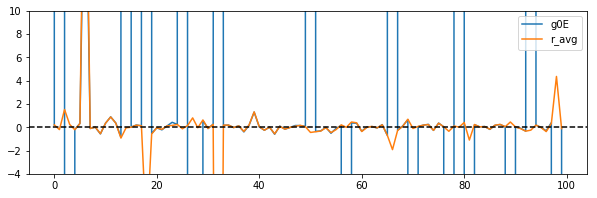

In [60]:
plt.figure(figsize=(10,3))
plt.plot(g0E, label='g0E')
plt.plot(r_avg, label='r_avg')
plt.axhline(y=0., color='k', linestyle='--')
plt.ylim(-4,10)
plt.legend()

For the rest of the time, the computation works very well!

Let us compute the experimental covariance matrix:

In [61]:
CE = compCE(PF, g0E)

An we need to compute the new expression of the theoretical covariance matrix:

In [62]:
def compCth_AR1 (N,sig,g0,g):
    I = np.identity(N)
    C = np.zeros((N,N))
    for i,j in itertools.product(range(N),range(N)):
        sumgi = g[:,i].sum()
        sumgj = g[:,j].sum()
        sumgigj = 0
        for k,r in itertools.product(range(P),range(P)):
            sumgigj += g[k,i]*g[r,j]
        C[i,j] = (g0[i]*g0[j] + sig**2 * I[i,j]) / (1-sumgigj) - g0[i]*g0[j] / (1-sumgi) / (1-sumgj)
    return C

In [63]:
Cth = compCth_AR1(N,sig,g0,g)

In [64]:
print(CE[0:5,0:5],'\n')
print(Cth[0:5,0:5])

[[ 1.35587527e+000  1.75037191e+008  1.54384163e-002  7.08768223e+124
  -1.84160779e-002]
 [ 1.75037191e+008  1.14560499e+021  5.98928154e+008 -1.95645276e+135
  -8.36923328e+008]
 [ 1.54384163e-002  5.98928154e+008  1.50325118e+000 -4.25013120e+124
  -3.68899739e-002]
 [ 7.08768223e+124 -1.95645276e+135 -4.25013120e+124  1.71025478e+252
  -3.49278435e+124]
 [-1.84160779e-002 -8.36923328e+008 -3.68899739e-002 -3.49278435e+124
   1.44956746e+000]] 

[[ 1.07257945e+00 -9.28824406e-04 -2.24718620e-01 -6.93481836e-02
   1.24552100e-02]
 [-9.28824406e-04  2.46978343e+00  2.10972480e-01  6.52173781e-02
   3.25788412e-02]
 [-2.24718620e-01  2.10972480e-01  1.33501558e-01 -9.63942279e+01
   2.36003597e-01]
 [-6.93481836e-02  6.52173781e-02 -9.63942279e+01 -1.12432184e+00
   7.19278807e-02]
 [ 1.24552100e-02  3.25788412e-02  2.36003597e-01  7.19278807e-02
   9.99706922e-01]]


In [65]:
def compareMatrices2 (A, B, subN=10, cmap='coolwarm', vmin={}, vmax={}):
    if(A.shape!=B.shape):
        ValueError('Dimension Error!')

    # compareMatrices2.__defaults__[2] and [3] are here equal to {}.
    if (vmin == compareMatrices2.__defaults__[2]):
        print('vmin NOT defined, taking minimum element of the two matrices.')
        vmin=min(A.min(), B.min())

    if (vmax == compareMatrices2.__defaults__[3]):
        print('vmax NOT defined, taking maximum element of the two matrices.')
        vmax=max(A.max(), B.max())
    
    fig, axs = plt.subplots(ncols=3, gridspec_kw=dict(wspace=0.1, width_ratios=[8,8,0.5]), figsize=(10,5))
    
    if(subN <= 10):
        annot_opt = True
    else:
        annot_opt = False
        
    sns.heatmap(A[0:subN,0:subN], annot=annot_opt, cbar=False, ax=axs[0], cmap=cmap, vmin=vmin, vmax=vmax)
    sns.heatmap(B[0:subN,0:subN], annot=annot_opt, yticklabels=False, cbar=False, ax=axs[1], cmap=cmap, vmin=vmin, vmax=vmax)

    fig.colorbar(axs[1].collections[0], cax=axs[2])
    plt.show()

vmin NOT defined, taking minimum element of the two matrices.
vmax NOT defined, taking maximum element of the two matrices.


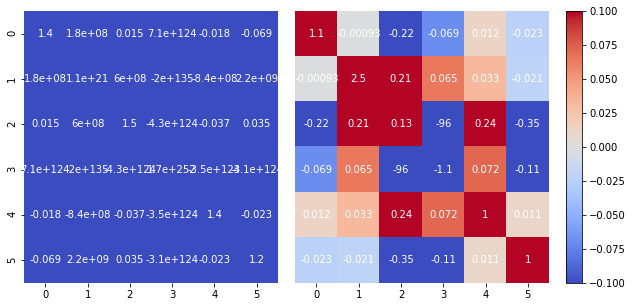

In [66]:
compareMatrices2(A=CE, B=Cth, subN=6, cmap='coolwarm')

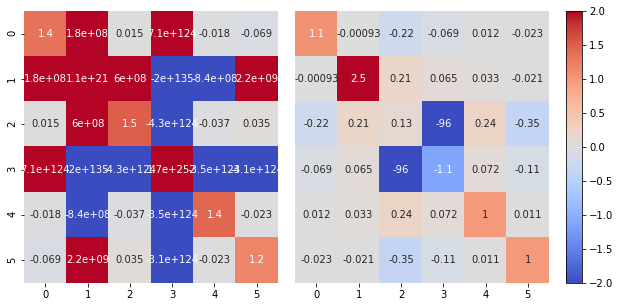

In [67]:
compareMatrices2(A=CE, B=Cth, subN=6, cmap='coolwarm', vmin=-2, vmax=2)

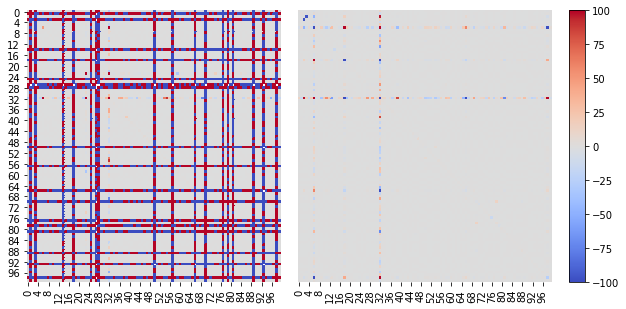

In [68]:
compareMatrices2(CE, Cth, N, cmap='coolwarm', vmin=-100, vmax=100)

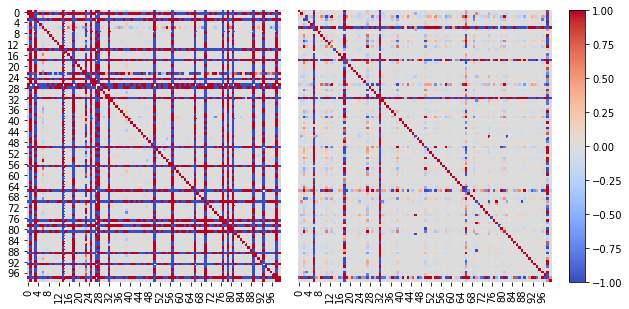

In [69]:
compareMatrices2(CE, Cth, N, cmap='coolwarm', vmin=-1, vmax=1)

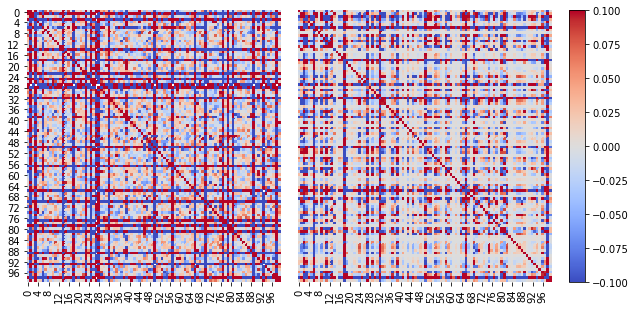

In [70]:
compareMatrices2(CE, Cth, N, cmap='coolwarm', vmin=-0.1, vmax=0.1)

As we can see the memory effect can lead to unstable evolutions over time, and hence extreme values.

Let us see the two different portfolios (longing all market and hedging the market):

In [71]:
GI, GII = compG(PF)

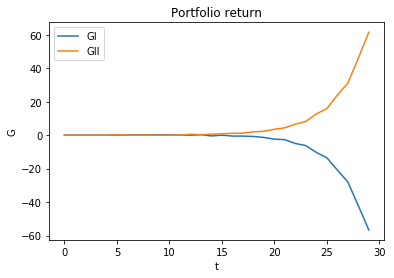

In [72]:
plt.plot(GI[0:30], label='GI')
plt.plot(GII[0:30], label='GII')
plt.xlabel('t')
plt.ylabel('G')
plt.title('Portfolio return')
plt.legend()

The two portfolios seem to have diverging total return. Their evolutions seem exponential.

Let's compute the lag-L autocovariance function $\gamma^L_i$ and the ACF $\rho^L_i$ for each stock:

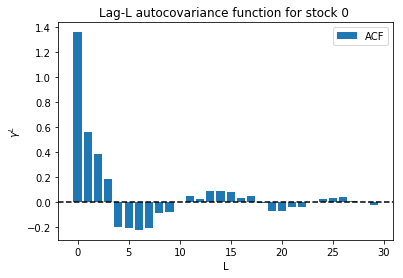

In [73]:
L = 30
gamma = compLagL_autocov(L,PF,g0E)

stock_id = 0
plt.bar(range(L), gamma[:,stock_id], label='ACF')
plt.axhline(y=0., color='k', linestyle='--')
plt.xlabel('L')
plt.ylabel('$\gamma^L$')
plt.title('Lag-L autocovariance function for stock 0 ')
plt.legend()

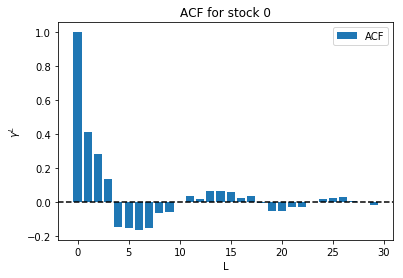

In [74]:
L = 30
ACF = compACF(L,PF,g0E)

stock_id = 0
plt.bar(range(L), ACF[:,stock_id], label='ACF')
plt.axhline(y=0., color='k', linestyle='--')
plt.xlabel('L')
plt.ylabel('$\gamma^L$')
plt.title('ACF for stock 0')
plt.legend()

Text(0.5, 1.0, 'Time window on stock 0')

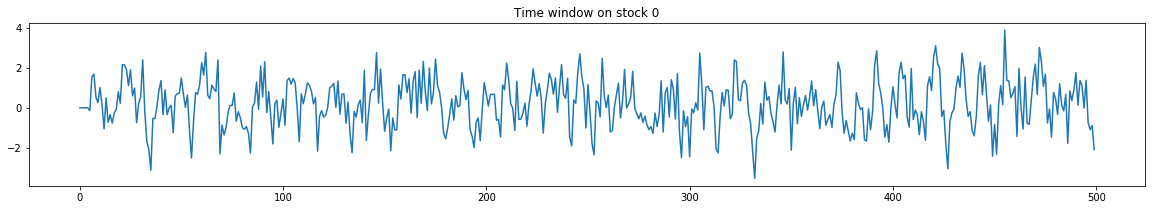

In [75]:
plt.figure(figsize=(20,3))
plt.plot(PF[:500,stock_id])
plt.title('Time window on stock 0')

Looking at other stocks:

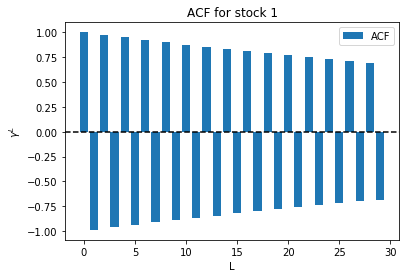

In [76]:
L = 30
ACF = compACF(L,PF,g0E)

stock_id = 1
plt.bar(range(L), ACF[:,stock_id], label='ACF')
plt.axhline(y=0., color='k', linestyle='--')
plt.xlabel('L')
plt.ylabel('$\gamma^L$')
plt.title('ACF for stock 1')
plt.legend()

Text(0.5, 1.0, 'Time window on stock 1')

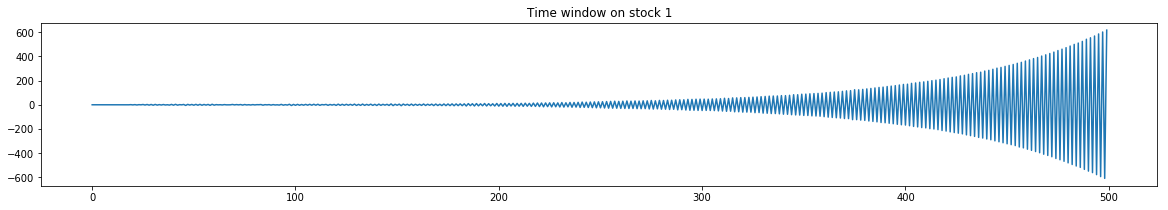

In [77]:
plt.figure(figsize=(20,3))
plt.plot(PF[:500,stock_id])
plt.title('Time window on stock 1')

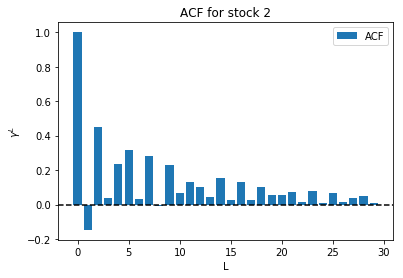

In [78]:
L = 30
ACF = compACF(L,PF,g0E)

stock_id = 2
plt.bar(range(L), ACF[:,stock_id], label='ACF')
plt.axhline(y=0., color='k', linestyle='--')
plt.xlabel('L')
plt.ylabel('$\gamma^L$')
plt.title('ACF for stock 2')
plt.legend()

Text(0.5, 1.0, 'Time window on stock 2')

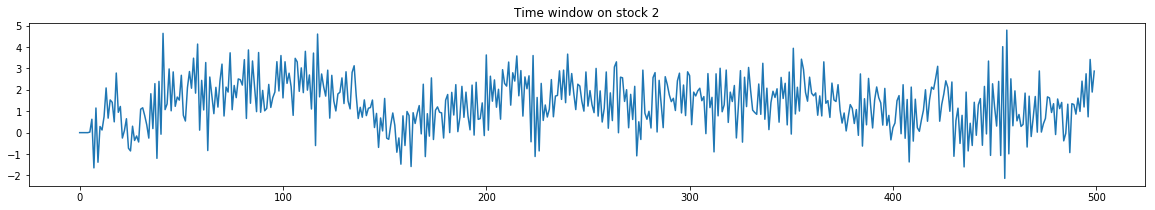

In [79]:
plt.figure(figsize=(20,3))
plt.plot(PF[:500,stock_id])
plt.title('Time window on stock 2')

As we can see, there are many different behaviours that can happen within the AR(p) model!

----

# MA(q) Model

We consider here the **moving average MA(q) model**. In this model, the return can be written as:

$$
r_i^t = h_i^0 + \sigma (\epsilon_i^t + h_i^1 \epsilon_i^{t-1} + h_i^2 \epsilon_i^{t-2} + \ldots + h_i^q \epsilon_i^{t-q})
$$

Here $h_i^0$ is a constant for stock $i$ and $\epsilon_i^t$ are idiosyncratic noises for stocks at different time.

We start with the **MA(1) model**:

$$
r_i^t = h_i^0 + \sigma(\epsilon_i^t + h_i^1 \epsilon_i^{t-1})
$$

In [80]:
N = 100
T = 2000
Q = 1
sig = 1

In [81]:
g0 = np.random.normal(loc=0., scale=0.3, size=N)

In [82]:
s = np.random.poisson(lam=30,size=Q+1) / 100. # Generating values for distributions of k=2,...,Q
print(s)

[0.38 0.35]


In [83]:
h = np.zeros((Q+1,N))
h[0] = np.full((1,N),1)
for k in range(1,Q+1):
    h[k] = np.random.normal(loc=0., scale=s[k], size=N)

In [84]:
eps = np.zeros((T,N))
for k in range(T):
    eps[k] = np.random.normal(loc=0., scale=1., size=N)

The model is computed in the following function:

In [85]:
np.random.seed(1234)

def buildPF_MAQmodel(T,sig,g0,h,eps):
    # Dimensions
    if (len(g0)!=len(h[0]) or len(g0)!=eps.shape[1]):
        ValueError('Dimension error.')
    else:
        N = len(g0)
        T = eps.shape[0]
        Q = h.shape[0]-1

    # Building portfolio
    PF = np.zeros((T,N))
    for i in range(N):
        for t in range(Q,T,1):
            sumNoises = 0
            for k in range(Q+1):
                sumNoises += h[k,i] * eps[t-k,i]
            PF[t,i] = g0[i] + sig * sumNoises
            
    return PF

In [86]:
PF = buildPF_MAQmodel(T,sig,g0,h,eps)

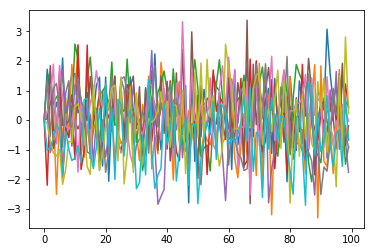

In [87]:
plt.plot(PF[:100,0:10])

Text(0.5, 1.0, 'Plot of 2 stocks agains each other')

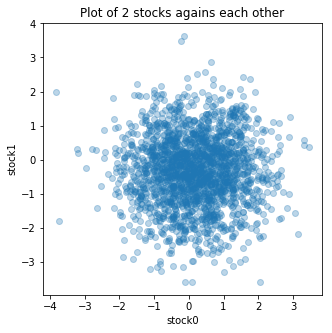

In [95]:
plt.figure(figsize=(5,5))
plt.scatter(PF[:,0], PF[:,1], alpha=0.3)
plt.xlabel("stock0")
plt.ylabel("stock1")
plt.title("Plot of 2 stocks agains each other")

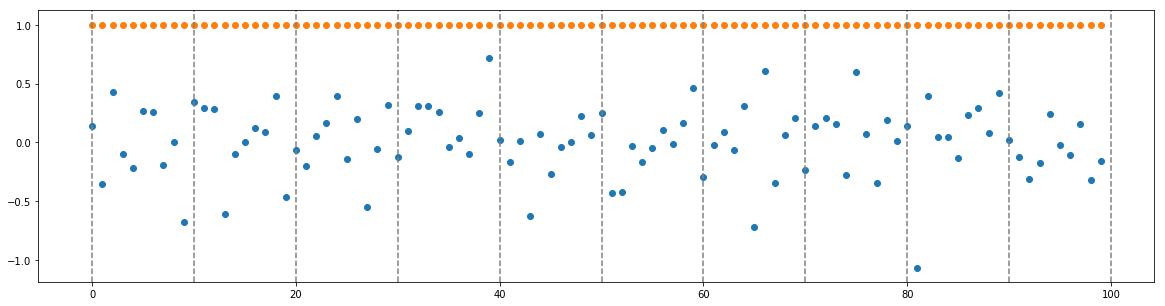

In [89]:
plt.figure(figsize=(20,5))
plt.scatter(range(N),g0)
for k in range(Q):
    plt.scatter(range(N),h[k,:])
for m in range(0,N+1,10):
    plt.axvline(x=m, color='grey', linestyle='--')

In [90]:
g0E = compgE(PF)

Since $\epsilon$ is a white noise, we expect the $E[r_i^t] = g_i^0$:

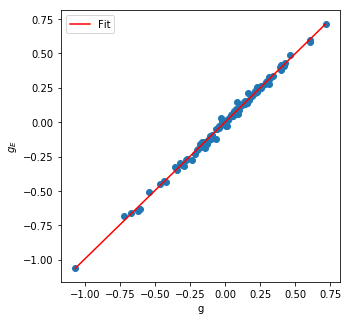

In [91]:
compare_g_gE(g0,g0E)

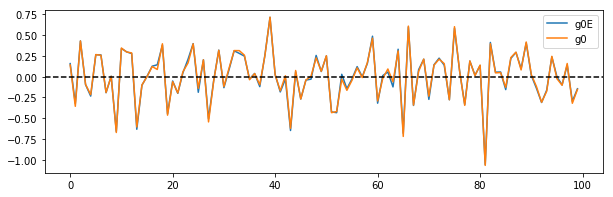

In [92]:
plt.figure(figsize=(10,3))
plt.plot(g0E, label='g0E')
plt.plot(g0, label='g0')
plt.axhline(y=0., color='k', linestyle='--')
plt.legend()

Text(0.5, 0, 't')

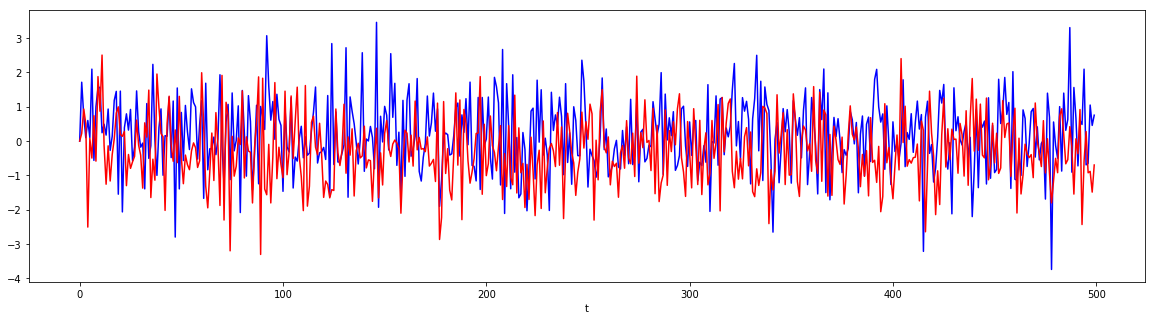

In [93]:
plt.figure(figsize=(20,5))
plt.plot(PF[:500,0], color='b')
plt.plot(PF[:500,1], color='r')
plt.xlabel('t')

Let us compute the experimental covariance matrix:

In [96]:
CE = compCE(PF, g0E)

An we need to compute the new expression of the theoretical covariance matrix:

In [97]:
def compCth_MAQ (sig,g0,h):
    # Dimensions
    if (len(g0)!=len(h[0]) or len(g0)!=h.shape[1]):
        ValueError('Dimension error.')
    else:
        N = len(g0)
        Q = h.shape[0]-1
        
    I = np.identity(N)
    C = np.zeros((N,N))
    for i,j in itertools.product(range(N),range(N)):
        sumhihj = 0
        for k in range(Q+1):
            sumhihj += h[k,i]*h[k,i]
        C[i,j] = sig**2 * sumhihj * I[i,j]
    return C

In [98]:
Cth = compCth_MAQ(sig,g0,h)

In [99]:
print(CE[0:5,0:5],'\n')
print(Cth[0:5,0:5])

[[ 1.06428765  0.00304816  0.03935474 -0.01525807  0.02517151]
 [ 0.00304816  1.07543815  0.02006996  0.01471181  0.02902172]
 [ 0.03935474  0.02006996  1.16404105 -0.02708151  0.02295237]
 [-0.01525807  0.01471181 -0.02708151  1.15019453 -0.00334386]
 [ 0.02517151  0.02902172  0.02295237 -0.00334386  1.11865149]] 

[[1.07474037 0.         0.         0.         0.        ]
 [0.         1.02683247 0.         0.         0.        ]
 [0.         0.         1.18369884 0.         0.        ]
 [0.         0.         0.         1.20105171 0.        ]
 [0.         0.         0.         0.         1.09389103]]


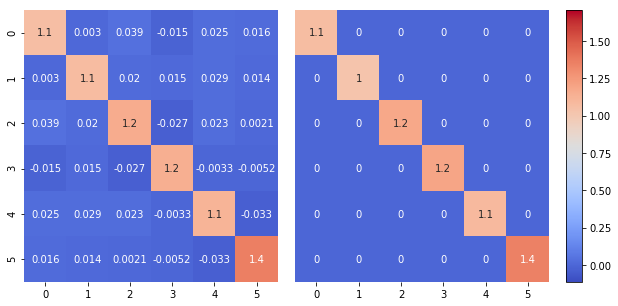

In [100]:
compareMatrices(A=CE, B=Cth, subN=6, cmap='coolwarm')

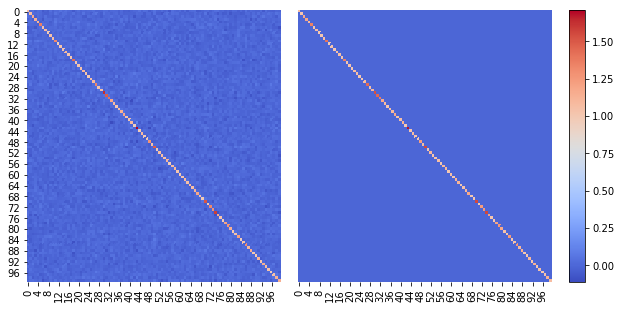

In [101]:
compareMatrices(CE, Cth, N)

Let us see the two different portfolios (longing all market and hedging the market):

In [102]:
GI, GII = compG(PF)

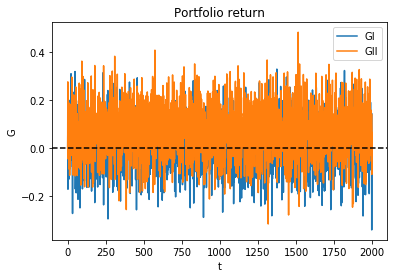

In [103]:
plt.plot(GI, label='GI')
plt.plot(GII, label='GII')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('t')
plt.ylabel('G')
plt.title('Portfolio return')
plt.legend()

In [104]:
print(GI.mean())
print(GII.mean())

0.010324538863356793
0.07512928111778197


In [105]:
print(g0.mean())
test = g0 * [(-1)**i for i in range(N)]
print(test.mean())

0.010533684937630952
0.07664521229842872


We can see that the half-long-half-short portfolio is more profitable that the all-long portfolio, at least in the case simulated here. We can also prove theoretically that the variances of both portfolios are equal, this seems attested by the above plot.

Let's compute the lag-L autocovariance function $\gamma^L_i$ and the ACF $\rho^L_i$ for each stock:

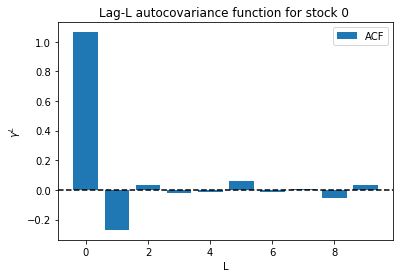

In [106]:
L = 10
gamma = compLagL_autocov(L,PF,g0E)

stock_id = 0
plt.bar(range(L), gamma[:,stock_id], label='ACF')
plt.axhline(y=0., color='k', linestyle='--')
plt.xlabel('L')
plt.ylabel('$\gamma^L$')
plt.title('Lag-L autocovariance function for stock 0 ')
plt.legend()

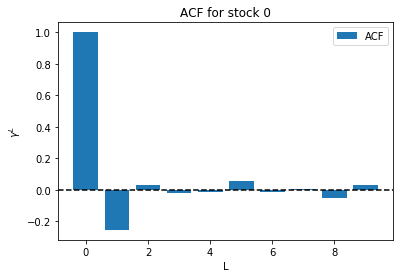

In [107]:
L = 10
ACF = compACF(L,PF,g0E)

stock_id = 0
plt.bar(range(L), ACF[:,stock_id], label='ACF')
plt.axhline(y=0., color='k', linestyle='--')
plt.xlabel('L')
plt.ylabel('$\gamma^L$')
plt.title('ACF for stock 0')
plt.legend()

Text(0.5, 1.0, 'Time window on stock 0')

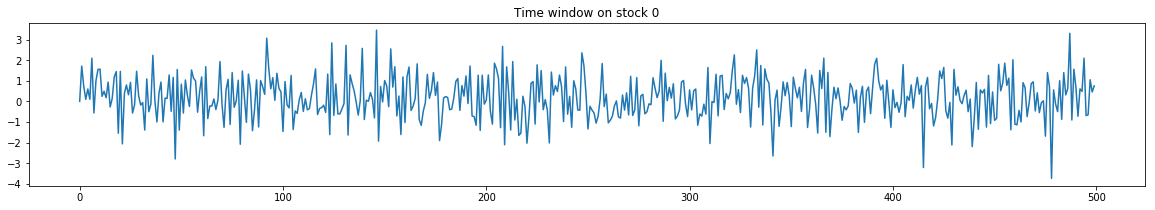

In [108]:
plt.figure(figsize=(20,3))
plt.plot(PF[:500,stock_id])
plt.title('Time window on stock 0')

Other stocks are similar here. But we can see from the ACF that the process is a MA(1) model since there is a cut at L=1.

Our code was written so that we can just change the value of Q and we have a **moving average MA(q) model**:

$$
r_i^t = h_i^0 + \sigma (\epsilon_i^t + h_i^1 \epsilon_i^{t-1} + h_i^2 \epsilon_i^{t-2} + \ldots + h_i^q \epsilon_i^{t-q})
$$

Let us explore this model now.

In [109]:
Q=5

In [110]:
g0 = np.random.normal(loc=0., scale=0.3, size=N)

In [111]:
s = np.random.poisson(lam=30,size=Q+1) / 100. # Generating values for distributions of k=2,...,Q
print(s)

[0.38 0.35 0.26 0.27 0.2  0.27]


In [112]:
h = np.zeros((Q+1,N))
h[0] = np.full((1,N),1)
for k in range(1,Q+1):
    h[k] = np.random.normal(loc=0., scale=s[k], size=N)

In [113]:
eps = np.zeros((T,N))
for k in range(T):
    eps[k] = np.random.normal(loc=0., scale=1., size=N)

In [114]:
PF = buildPF_MAQmodel(T,sig,g0,h,eps)

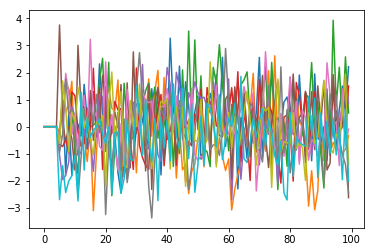

In [115]:
plt.plot(PF[:100,0:10])

Text(0.5, 1.0, 'Plot of 2 stocks agains each other')

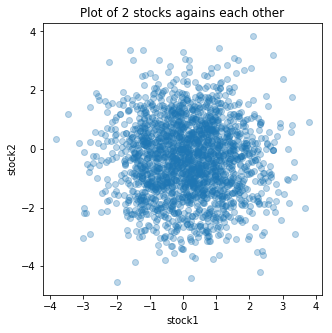

In [116]:
plt.figure(figsize=(5,5))
plt.scatter(PF[:,0], PF[:,1], alpha=0.3)
plt.xlabel("stock1")
plt.ylabel("stock2")
plt.title("Plot of 2 stocks agains each other")

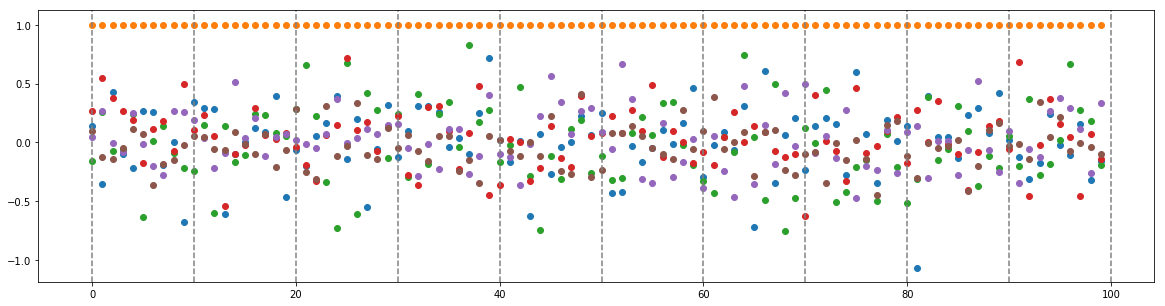

In [117]:
plt.figure(figsize=(20,5))
plt.scatter(range(N),g0)
for k in range(Q):
    plt.scatter(range(N),h[k,:])
for m in range(0,N+1,10):
    plt.axvline(x=m, color='grey', linestyle='--')

In [118]:
g0E = compgE(PF)

Since $\epsilon$ is a white noise, we expect the $E[r_i^t] = g_i^0$:

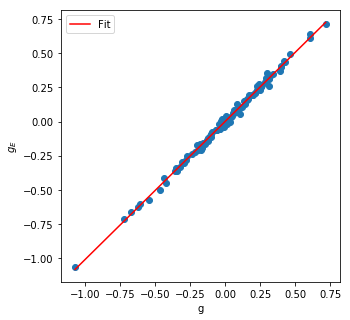

In [119]:
compare_g_gE(g0,g0E)

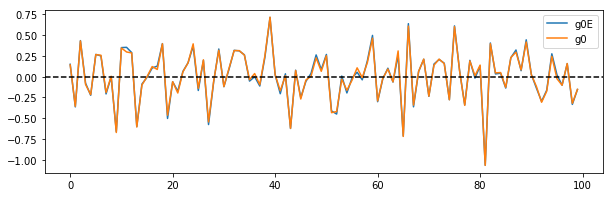

In [120]:
plt.figure(figsize=(10,3))
plt.plot(g0E, label='g0E')
plt.plot(g0, label='g0')
plt.axhline(y=0., color='k', linestyle='--')
plt.legend()

Text(0.5, 0, 't')

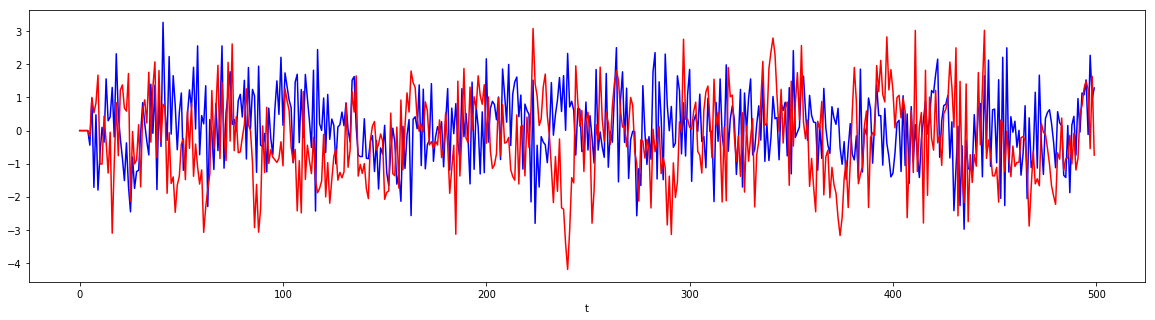

In [121]:
plt.figure(figsize=(20,5))
plt.plot(PF[:500,0], color='b')
plt.plot(PF[:500,1], color='r')
plt.xlabel('t')

Let us compute the experimental covariance matrix:

In [122]:
CE = compCE(PF, g0E)

And the theoretical covariance matrix:

In [123]:
Cth = compCth_MAQ(sig,g0,h)

In [124]:
print(CE[0:5,0:5],'\n')
print(Cth[0:5,0:5])

[[ 1.32629389 -0.02575855 -0.01168908  0.02953974  0.01779043]
 [-0.02575855  1.67743002  0.01060131 -0.01730788 -0.02522801]
 [-0.01168908  0.01060131  1.26436779 -0.03650394  0.01109783]
 [ 0.02953974 -0.01730788 -0.03650394  1.11836299 -0.00722702]
 [ 0.01779043 -0.02522801  0.01109783 -0.00722702  1.17442708]] 

[[1.32434918 0.         0.         0.         0.        ]
 [0.         1.60564458 0.         0.         0.        ]
 [0.         0.         1.26843239 0.         0.        ]
 [0.         0.         0.         1.0822271  0.        ]
 [0.         0.         0.         0.         1.18026678]]


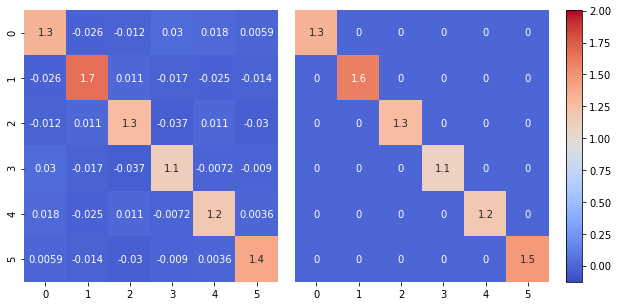

In [125]:
compareMatrices(A=CE, B=Cth, subN=6, cmap='coolwarm')

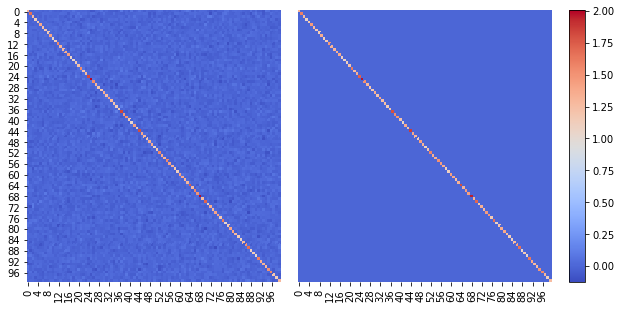

In [126]:
compareMatrices(CE, Cth, N)

Let us see the two different portfolios (longing all market and hedging the market):

In [127]:
GI, GII = compG(PF)

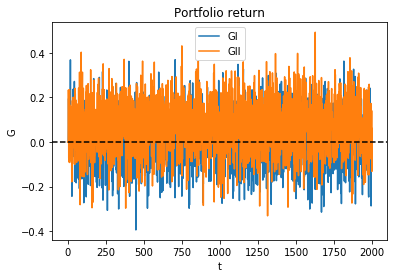

In [128]:
plt.plot(GI, label='GI')
plt.plot(GII, label='GII')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('t')
plt.ylabel('G')
plt.title('Portfolio return')
plt.legend()

In [129]:
print(GI.mean())
print(GII.mean())

0.010828546667159237
0.07367298756792846


In [130]:
print(g0.mean())
test = g0 * [(-1)**i for i in range(N)]
print(test.mean())

0.010533684937630952
0.07664521229842872


Again, we can see that the half-long-half-short portfolio is more profitable that the all-long portfolio, at least in the case simulated here. We can also prove theoretically that the variances of both portfolios are equal, this seems attested by the above plot.

Let's compute the lag-L autocovariance function $\gamma^L_i$ and the ACF $\rho^L_i$ for each stock:

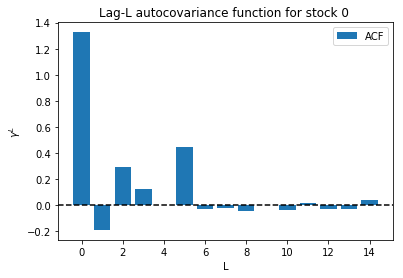

In [131]:
L = 15
gamma = compLagL_autocov(L,PF,g0E)

stock_id = 0
plt.bar(range(L), gamma[:,stock_id], label='ACF')
plt.axhline(y=0., color='k', linestyle='--')
plt.xlabel('L')
plt.ylabel('$\gamma^L$')
plt.title('Lag-L autocovariance function for stock 0 ')
plt.legend()

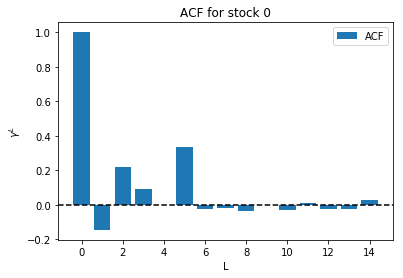

In [132]:
L = 15
ACF = compACF(L,PF,g0E)

stock_id = 0
plt.bar(range(L), ACF[:,stock_id], label='ACF')
plt.axhline(y=0., color='k', linestyle='--')
plt.xlabel('L')
plt.ylabel('$\gamma^L$')
plt.title('ACF for stock 0')
plt.legend()

Text(0.5, 1.0, 'Time window on stock 0')

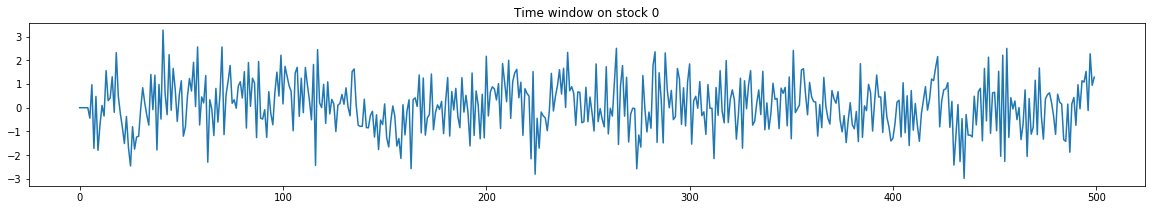

In [133]:
plt.figure(figsize=(20,3))
plt.plot(PF[:500,stock_id])
plt.title('Time window on stock 0')

Let's test two other stock just for curiosity stake:

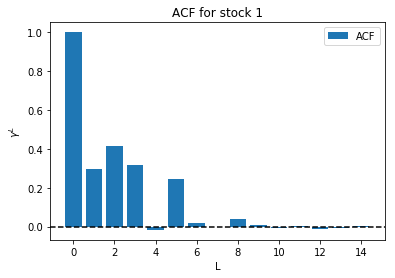

In [134]:
L = 15
ACF = compACF(L,PF,g0E)

stock_id = 1
plt.bar(range(L), ACF[:,stock_id], label='ACF')
plt.axhline(y=0., color='k', linestyle='--')
plt.xlabel('L')
plt.ylabel('$\gamma^L$')
plt.title('ACF for stock 1')
plt.legend()

Text(0.5, 1.0, 'Time window on stock 1')

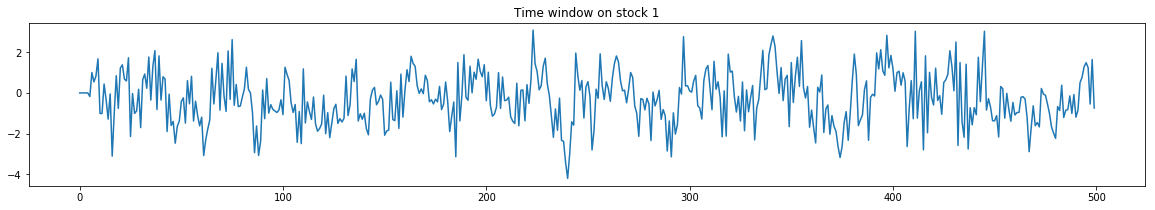

In [135]:
plt.figure(figsize=(20,3))
plt.plot(PF[:500,stock_id])
plt.title('Time window on stock 1')

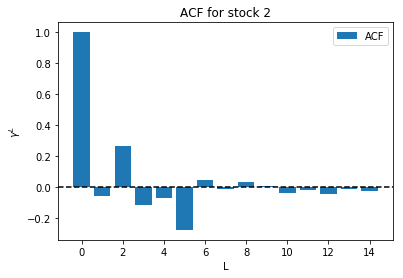

In [136]:
L = 15
ACF = compACF(L,PF,g0E)

stock_id = 2
plt.bar(range(L), ACF[:,stock_id], label='ACF')
plt.axhline(y=0., color='k', linestyle='--')
plt.xlabel('L')
plt.ylabel('$\gamma^L$')
plt.title('ACF for stock 2')
plt.legend()

Text(0.5, 1.0, 'Time window on stock 2')

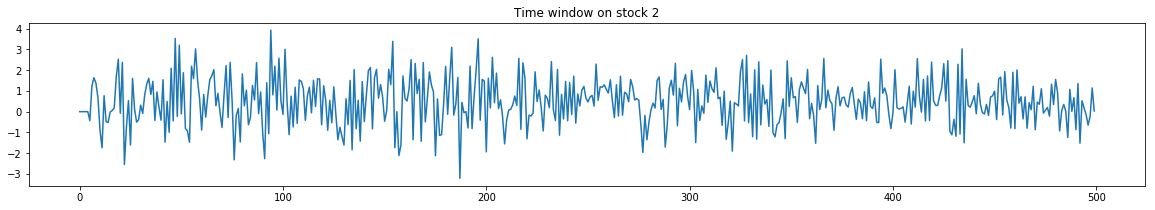

In [137]:
plt.figure(figsize=(20,3))
plt.plot(PF[:500,stock_id])
plt.title('Time window on stock 2')

It is hard to see a difference in the time series, but what is obvious is that the autocorrelation function (ACF) tend to have large values for $L \leq Q$, and cuts at $L = Q$ as expected.

We have seen also a very important property of the **MA(q) model: it is always stationary ! (contrary to the AR(p) model)**

### Random Walk (without and with drift)

As a last model, we will test a simple Random Walk model described by:

$$
r_i^t = g_i^0 + r_i^{t-1} + \sigma \epsilon_i^t
$$

We can see that it is equivalent to an AR(1) model for which the coefficient of the memory term is unity. Since the AR(p) models can diverge for large coefficients, this is what we expect here to happen.

In [138]:
N = 100
T = 2000
sig = 1

In [139]:
g0 = np.random.normal(loc=0., scale=0.3, size=N)

In [140]:
eps = np.zeros((T,N))
for k in range(T):
    eps[k] = np.random.normal(loc=0., scale=1., size=N)

The model is computed in the following function:

In [141]:
np.random.seed(1234)

def buildPF_RWmodel(sig,g0,eps):
    # Dimensions
    if (len(g0)!=eps.shape[1]):
        ValueError('Dimension error.')
    else:
        N = len(g0)
        T = eps.shape[0]

    # Building portfolio
    PF = np.zeros((T,N))
    for i in range(N):
        for t in range(1,T,1):
            PF[t,i] = g0[i] + PF[t-1,i] + sig * eps[t,i]
            
    return PF

In [142]:
PF = buildPF_RWmodel(sig,g0,eps)

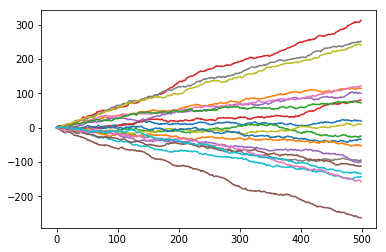

In [143]:
plt.plot(PF[:500,0:20])

Text(0.5, 1.0, 'Plot of 2 stocks agains each other')

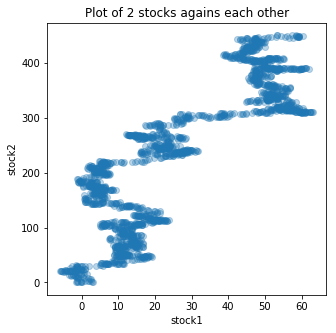

In [144]:
plt.figure(figsize=(5,5))
plt.scatter(PF[:,0], PF[:,1], alpha=0.3)
plt.xlabel("stock1")
plt.ylabel("stock2")
plt.title("Plot of 2 stocks agains each other")

In [145]:
g0E = compgE(PF)

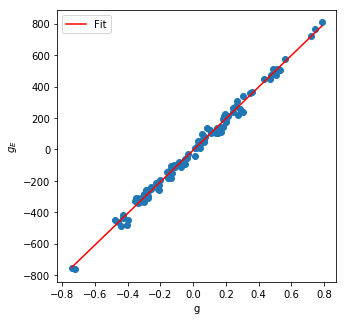

In [146]:
compare_g_gE(g0,g0E)

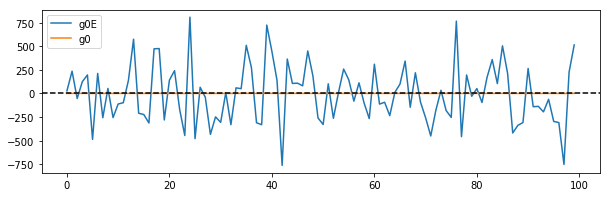

In [147]:
plt.figure(figsize=(10,3))
plt.plot(g0E, label='g0E')
plt.plot(g0, label='g0')
plt.axhline(y=0., color='k', linestyle='--')
plt.legend()

We can see that the average g0E computed here make no real sense, this is simply because **the random walk with a drift does not satisfy the weak stationarity condition.** It is easy to see that averaging returns over a longer period of time would lead to different values of g0E.

Let us compute the experimental covariance matrix (even though its meaning depend on the time window):

In [148]:
CE = compCE(PF, g0E)

An we need to compute the new expression of the theoretical covariance matrix:

In [149]:
def compCth_MAQ (T,N,sig):
    I = np.identity(N)
    C = np.zeros((N,N))
    for i,j in itertools.product(range(N),range(N)):
        C[i,j] = T * sig**2 * I[i,j]
    return C

In [150]:
Cth = compCth_MAQ(T,N,sig)

In [151]:
print(CE[0:5,0:5],'\n')
print(Cth[0:5,0:5])

[[  390.23079382  2119.23569075  -415.42173582  1013.65419026
   1688.43712981]
 [ 2119.23569075 16188.16147211 -3879.96973234  8373.53896087
  13003.02108954]
 [ -415.42173582 -3879.96973234  1082.79308294 -2094.8442287
  -3103.14284719]
 [ 1013.65419026  8373.53896087 -2094.8442287   4489.81466495
   6786.88646263]
 [ 1688.43712981 13003.02108954 -3103.14284719  6786.88646263
  10631.43939514]] 

[[2000.    0.    0.    0.    0.]
 [   0. 2000.    0.    0.    0.]
 [   0.    0. 2000.    0.    0.]
 [   0.    0.    0. 2000.    0.]
 [   0.    0.    0.    0. 2000.]]


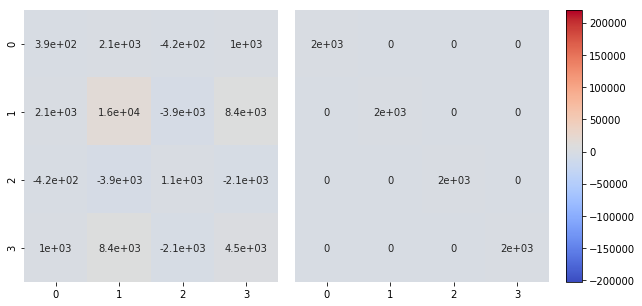

In [152]:
compareMatrices(A=CE, B=Cth, subN=4, cmap='coolwarm')

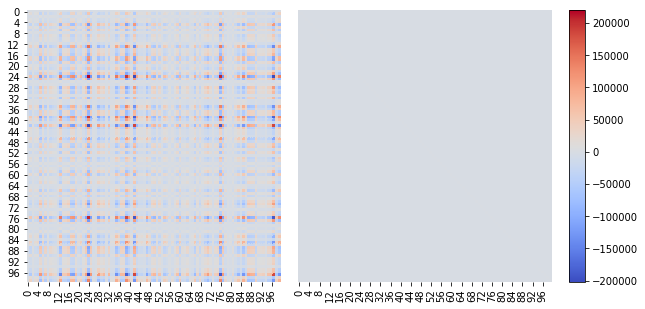

In [153]:
compareMatrices(CE, Cth, N)

The two matrices are different and there is no real surprise about that since **the weak stationarity assumption is broken**.

In [154]:
GI, GII = compG(PF)

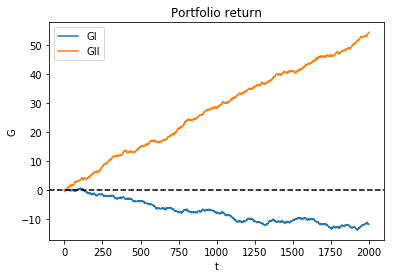

In [155]:
plt.plot(GI, label='GI')
plt.plot(GII, label='GII')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('t')
plt.ylabel('G')
plt.title('Portfolio return')
plt.legend()

This shows again the lack of stationarity mentionned above.

Text(0.5, 1.0, 'Lag-L autocovariance function for stock 0')

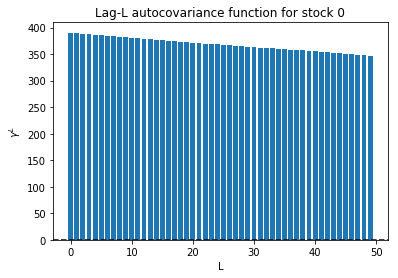

In [156]:
L = 50
gamma = compLagL_autocov(L,PF,g0E)

stock_id = 0
plt.bar(range(L), gamma[:,stock_id])
plt.axhline(y=0., color='k', linestyle='--')
plt.xlabel('L')
plt.ylabel('$\gamma^L$')
plt.title('Lag-L autocovariance function for stock 0')

Text(0.5, 1.0, 'ACF for stock 0')

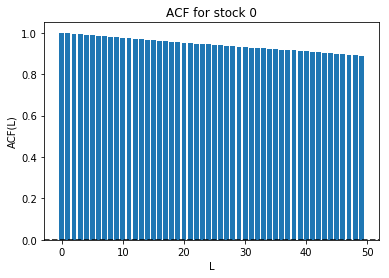

In [157]:
L = 50
ACF = compACF(L,PF,g0E)

stock_id = 0
plt.bar(range(L), ACF[:,stock_id])
plt.axhline(y=0., color='k', linestyle='--')
plt.xlabel('L')
plt.ylabel('ACF(L)')
plt.title('ACF for stock 0')

We can see that the decrease in values of the ACF is very slow, which indicates that we have a very long memory process here, going along with the non-convergence of that process.

**What if we remove the drift?**

The **Random Walk process with no drift** is thus described by:

$$
r_i^t = r_i^{t-1} + \sigma \epsilon_i^t
$$

In [158]:
N = 100
T = 2000
sig = 1

In [159]:
zeros = np.zeros(N)

In [160]:
eps = np.zeros((T,N))
for k in range(T):
    eps[k] = np.random.normal(loc=0., scale=1., size=N)

In [161]:
PF = buildPF_RWmodel(sig,zeros,eps)

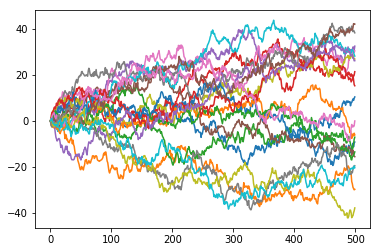

In [162]:
plt.plot(PF[:500,0:20])

Text(0.5, 1.0, 'Plot of 2 stocks agains each other')

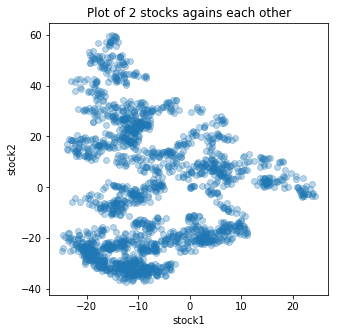

In [163]:
plt.figure(figsize=(5,5))
plt.scatter(PF[:,0], PF[:,1], alpha=0.3)
plt.xlabel("stock1")
plt.ylabel("stock2")
plt.title("Plot of 2 stocks agains each other")

In [164]:
g0E = compgE(PF)

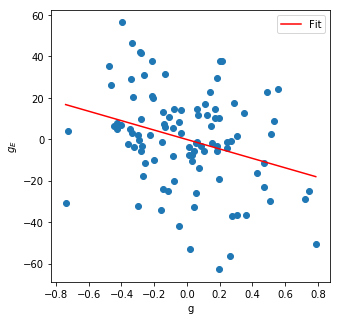

In [165]:
compare_g_gE(g0,g0E)

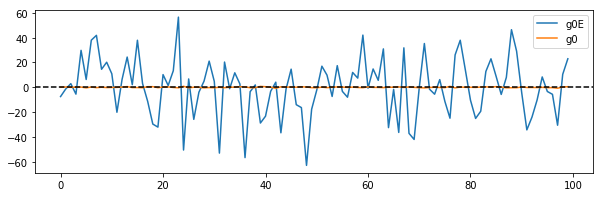

In [166]:
plt.figure(figsize=(10,3))
plt.plot(g0E, label='g0E')
plt.plot(g0, label='g0')
plt.axhline(y=0., color='k', linestyle='--')
plt.legend()

We can see also here that the average g0E make no real sense (dependence on time window of averaging), because **the random walk process does not satisfy the weak stationarity condition, even when there is no drift**.

Let us compute the experimental covariance matrix (even though its meaning depend on the time window):

In [168]:
CE = compCE(PF, g0E)

An we need to compute the new expression of the theoretical covariance matrix:

In [169]:
Cth = compCth_MAQ(T,N,sig)

In [170]:
print(CE[0:5,0:5],'\n')
print(Cth[0:5,0:5])

[[ 102.27662736   -6.69731555   -9.90498188   20.09195782  -54.34273129]
 [  -6.69731555  566.91689182   96.0398646  -323.09709233  102.60475093]
 [  -9.90498188   96.0398646    80.16790225  -98.33112008   27.21645099]
 [  20.09195782 -323.09709233  -98.33112008  278.35094637  -54.78333016]
 [ -54.34273129  102.60475093   27.21645099  -54.78333016   90.27919269]] 

[[2000.    0.    0.    0.    0.]
 [   0. 2000.    0.    0.    0.]
 [   0.    0. 2000.    0.    0.]
 [   0.    0.    0. 2000.    0.]
 [   0.    0.    0.    0. 2000.]]


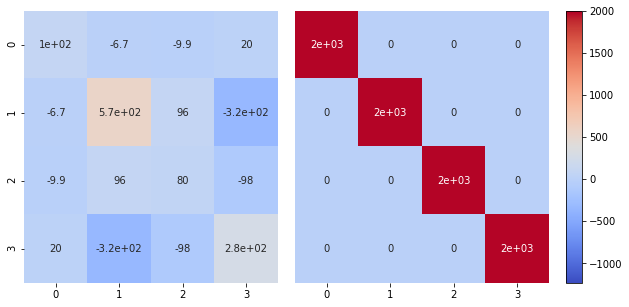

In [171]:
compareMatrices(A=CE, B=Cth, subN=4, cmap='coolwarm')

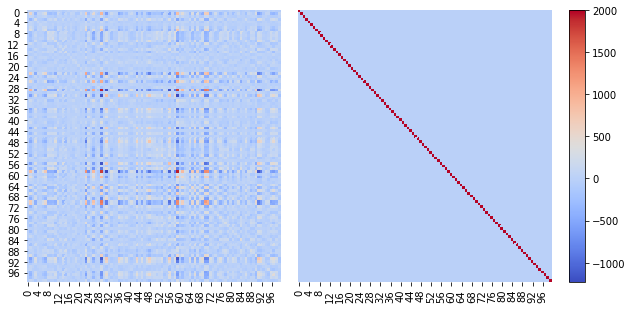

In [172]:
compareMatrices(CE, Cth, N)

Once again, since **the weak stationarity assumption is broken**, the computation of the covariance matrix breaks down.

In [173]:
GI, GII = compG(PF)

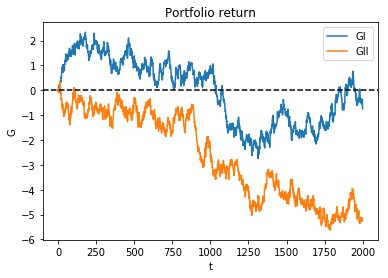

In [174]:
plt.plot(GI, label='GI')
plt.plot(GII, label='GII')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('t')
plt.ylabel('G')
plt.title('Portfolio return')
plt.legend()

This shows again the lack of stationarity mentionned above, but this time the drift is not present. We just have a pure random walk around the average.

Text(0.5, 1.0, 'Lag-L autocovariance function for stock 0')

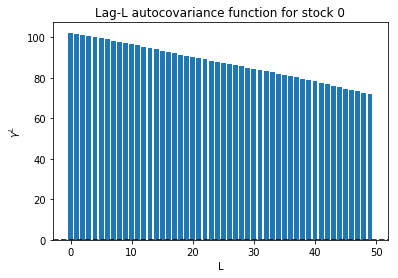

In [175]:
L = 50
gamma = compLagL_autocov(L,PF,g0E)

stock_id = 0
plt.bar(range(L), gamma[:,stock_id])
plt.axhline(y=0., color='k', linestyle='--')
plt.xlabel('L')
plt.ylabel('$\gamma^L$')
plt.title('Lag-L autocovariance function for stock 0')

Text(0.5, 1.0, 'ACF for stock 0')

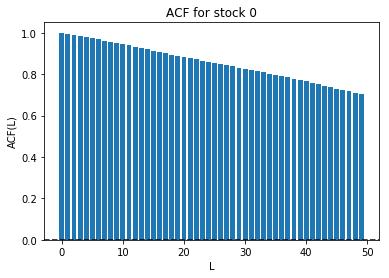

In [176]:
L = 50
ACF = compACF(L,PF,g0E)

stock_id = 0
plt.bar(range(L), ACF[:,stock_id])
plt.axhline(y=0., color='k', linestyle='--')
plt.xlabel('L')
plt.ylabel('ACF(L)')
plt.title('ACF for stock 0')

The decrease in values of the ACF is faster than the case with drift, but still slow, indicating that we have a very long memory process with no convergence.

----

**That's all folks! :-)**